In [1]:
import os
import mediapipe as mp
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.9)

In [3]:
data_dir = 'ASL_Dataset/Train'
data = []
labels = []

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Get a list of all subdirectories (labels)
label_dirs = [d for d in sorted(os.listdir(data_dir)) if d != '.DS_Store']
total_files = sum(len(files) for label in label_dirs for _, _, files in os.walk(os.path.join(data_dir, label)))

# Process each image with a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for label in label_dirs:
        label_path = os.path.join(data_dir, label)
        for img_name in os.listdir(label_path):
            data_aux = []
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                pbar.update(1)
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Process image to get hand landmarks
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    for landmark in hand_landmarks.landmark:
                        data_aux.append(landmark.x)
                        data_aux.append(landmark.y)
                data.append(data_aux)
                labels.append(label)
            pbar.update(1)

# Close the hands object
hands.close()

# Save data to pickle file
with open('data.pickle', 'wb') as f:
    pickle.dump({'data': data, 'labels': labels}, f)

Processing Images: 100%|█████████████████████████████████████████████████████| 165670/165670 [1:32:01<00:00, 30.01it/s]


C:\Users\user\AppData\Local\Temp\ipykernel_18940\832689798.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


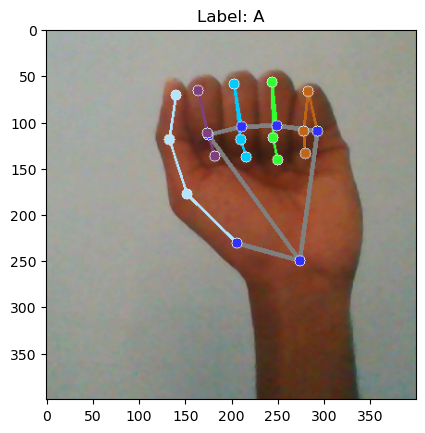

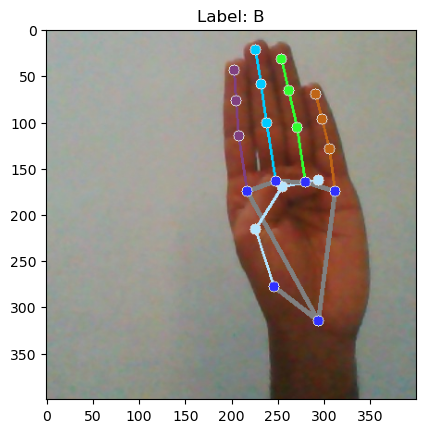

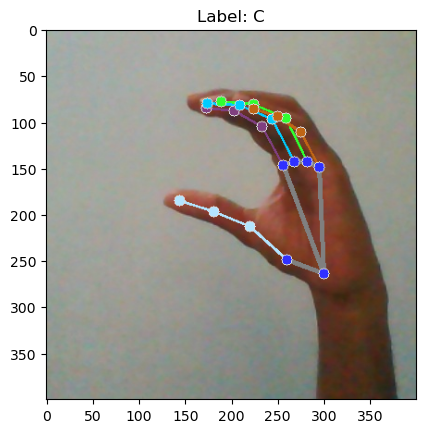

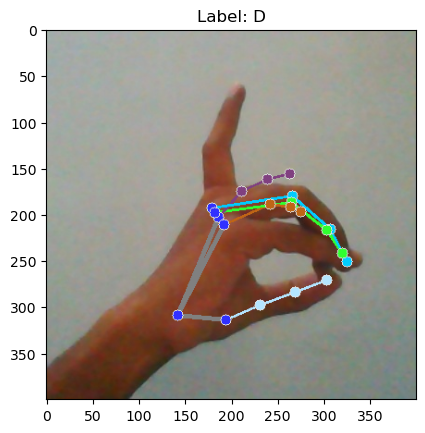

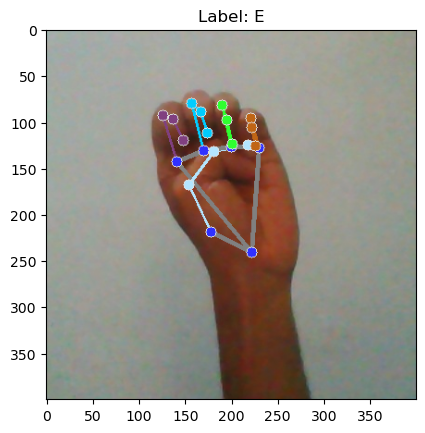

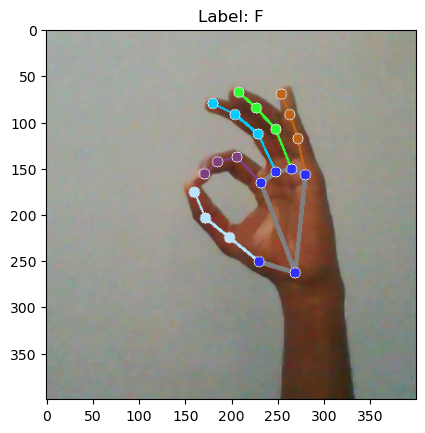

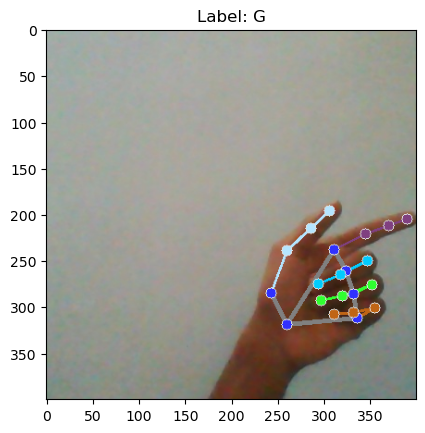

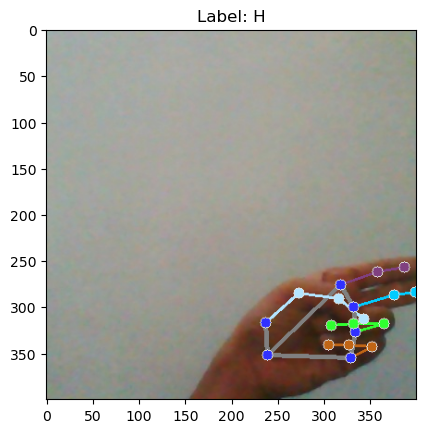

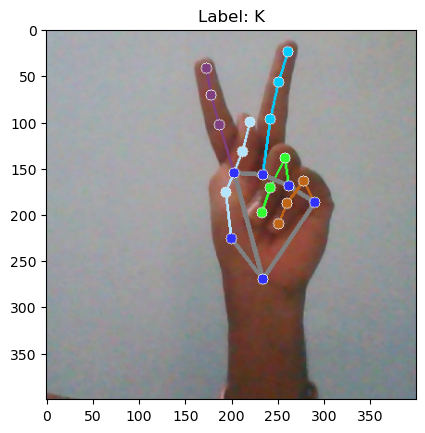

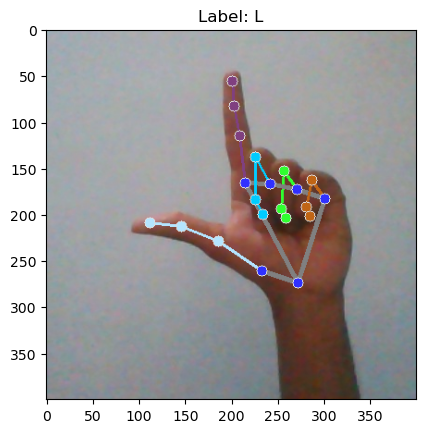

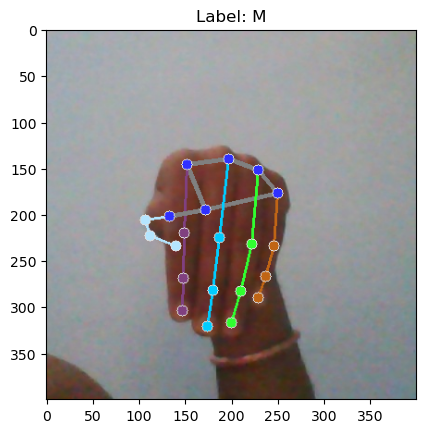

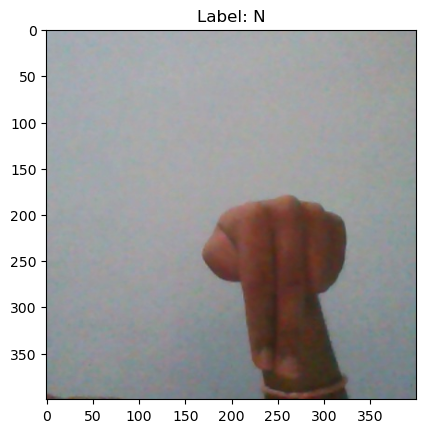

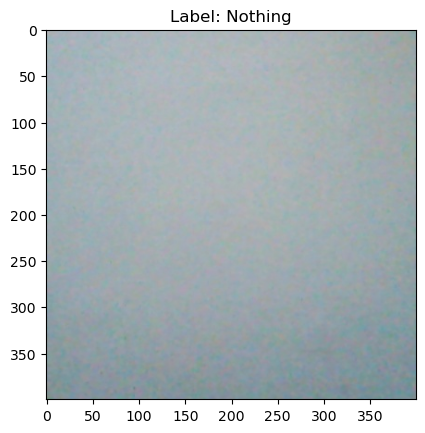

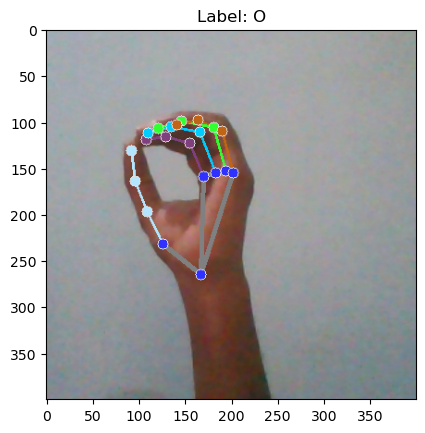

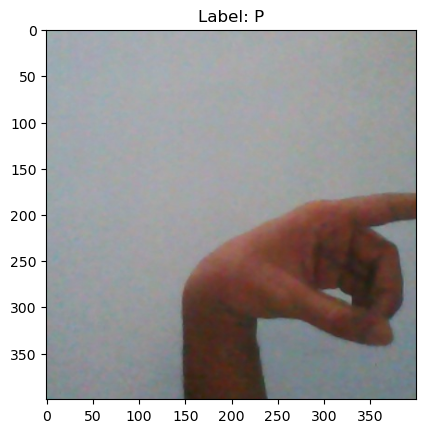

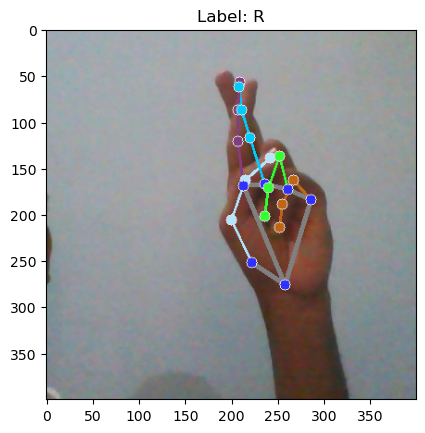

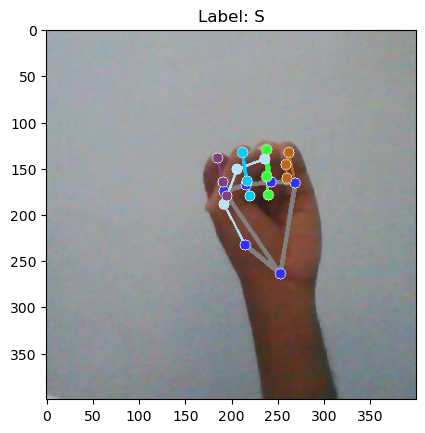

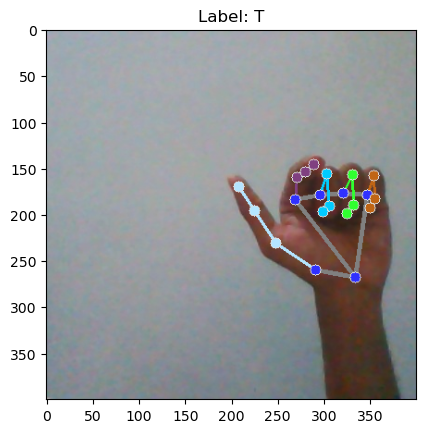

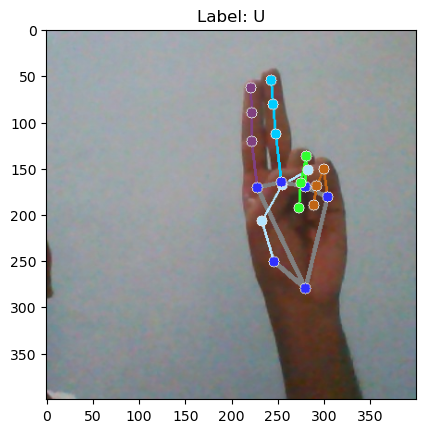

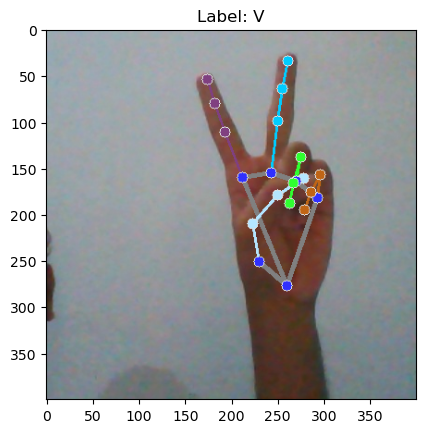

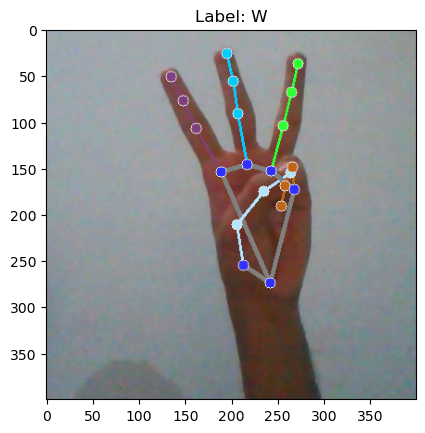

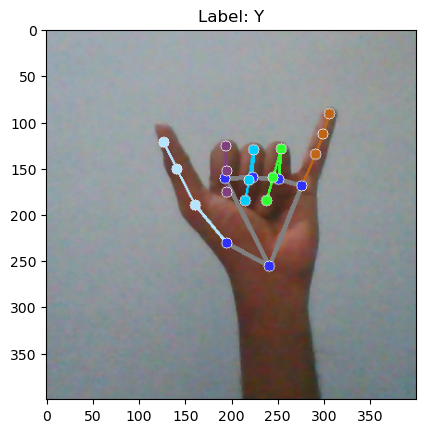

In [4]:
# Initialize MediaPipe components
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Initialize the Hands model
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Set the directory
data_dir = 'ASL_Dataset/Train'

# Loop through each label directory and visualize landmarks on one sample image per label
for i in sorted(os.listdir(data_dir)):
    if i == '.DS_Store':
        continue
    else:
        for j in os.listdir(os.path.join(data_dir, i))[0:1]:  # Take the first image only
            img_path = os.path.join(data_dir, i, j)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Process the image to detect hand landmarks
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Draw the hand landmarks on the image
                    mp_drawing.draw_landmarks(
                        img_rgb,  # Image to draw on
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style()
                    )

            # Display the image with landmarks
            plt.figure()
            plt.title(f"Label: {i}")
            plt.imshow(img_rgb)

# Show all images at once
plt.show()

# Release resources
hands.close()

In [5]:
# split data
X_train, X_test, y_train, y_test = train_test_split(np.array(data), labels, test_size=0.15, random_state=22, shuffle=True)

# model
model = RandomForestClassifier(random_state=22)
model.fit(X_train,y_train)

# predict
pred=model.predict(X_test)

# accruracy
accuracy_score(y_test,pred)

0.9994274893204739

In [6]:
# save model
f = open('model.p', 'wb')
pickle.dump({'model':model},f)
f.close() 

In [3]:
# load model
model_dict = pickle.load(open('model/model.p','rb'))
model = model_dict['model']

In [5]:
cap = cv2.VideoCapture(0)

with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.8) as hands:
    while cap.isOpened():

        data_aux=[]
        x_ = []
        y_ = []

        ret, frame = cap.read()
        H, W, _ = frame.shape
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.flip(frame_rgb, 1)
        frame_rgb.flags.writeable = False
        results = hands.process(frame_rgb)
        frame_rgb.flags.writeable = True 
        frame_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    frame_rgb, # img to draw
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(28, 255, 3), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(236, 255, 3), thickness=2, circle_radius=2)
                )

            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x)
                    data_aux.append(y)
                    x_.append(x)
                    y_.append(y)

            x1 = int(min(x_) * W)-10
            y1 = int(min(y_) * H)-10

            x2 = int(max(x_) * W)-10
            y2 = int(max(y_) * H)-10
            prediction = model.predict([np.array(data_aux)[0:42]])[0]

            cv2.rectangle(frame_rgb, (x1,y1-10), (x2,y2), (255,99,173), 6)
            cv2.putText(frame_rgb, prediction, (x1,y1), cv2.FONT_HERSHEY_DUPLEX, 5, (255,0,0), 5, cv2.LINE_AA)

        cv2.imshow('frame',frame_rgb)  
        # cv2.waitKey(1)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()